# TP 1

In [1]:
import random
from math import exp, sqrt, ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import panel as pn

pn.extension()

In [2]:
plt.rcParams['figure.figsize'] = [4, 3]

## Exercice 1

Simuler un marché selon les informations données. Et tracer le graphique.

In [3]:
# Variable globale, pour l'utiliser dans l'exercice 2.
df_s: pd.DataFrame

def mpl_plot(s: pd.DataFrame):
    fig = Figure()
    ax = fig.add_subplot()
    s.plot(ax=ax)
    return fig

def get_s(T=5 * 365, vol=0.2, rate=0.04):
    s0 = 1
    s = [0] * (T + 1)
    s[0] = s0
    for i in range(0, T):
        s[i + 1] = s[i] * exp((rate - (vol**2)/2) * (1/365) + vol * sqrt(1/365) * np.random.normal(loc = 0.0, scale = 1.0, size = None))
    
    
    global df_s 
    df_s = pd.DataFrame(s, columns=["Sous-jacent"])
    
    return mpl_plot(df_s)
    

Row
    [0] ParamFunction(function)
    [1] Column
        [0] IntSlider(end=3650, name='T', start=365, value=1825)
        [1] FloatSlider(name='vol', value=0.2)
        [2] FloatSlider(end=0.2, name='rate', step=0.01, value=0.04)
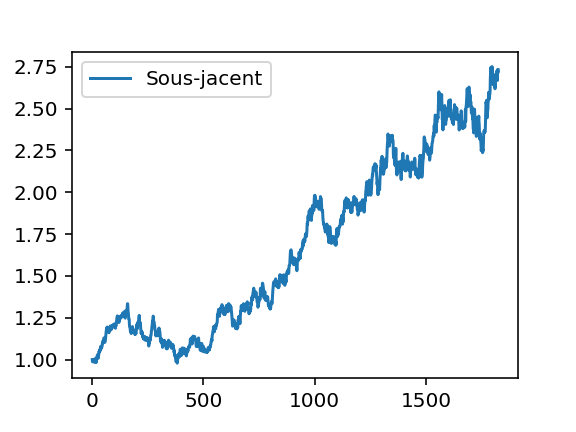

In [4]:
maturity_wid = pn.widgets.IntSlider(name='T', value=5 * 365, start=365, end=10 * 365)
volatily_wid = pn.widgets.FloatSlider(name='vol', value=0.2, start=0, end=1, step=0.1)
rate_wid = pn.widgets.FloatSlider(name='rate', value=0.04, start=0, end=0.20, step=0.01)

reactive_get_s = pn.bind(get_s, maturity_wid, volatily_wid, rate_wid)

widgets = pn.Column(maturity_wid, volatily_wid, rate_wid)
reactive_output_get_s = pn.Row(reactive_get_s, widgets)
reactive_output_get_s

## Exercice 2

Simuler la perfomance du fond avec la méthode du coussin.

In [5]:
# Variable globale, pour l'utiliser dans l'exercice 2.
df_nav: pd.DataFrame

def mpl_mutiple_plot(nav, s, bondfloor, expo):
    fig = Figure()
    ax = fig.add_subplot()
    nav.plot(ax=ax)
    s.plot(ax=ax)
    bondfloor.plot(ax=ax)
    expo.plot(ax=ax)
    return fig


def fond_methode_coussin(multiplicateur=3, garantie=1, T=maturity_wid.value, r=rate_wid.value):
    # Création des variables
    nav = [0] * (T + 1)
    ar = [0] * (T + 1)
    bondfloor = [0] * (T + 1)
    coussin = [0] * (T + 1)
    expo = [0] * (T + 1)
    nav_rendement = [0] * (T + 1)
    s_rendement = [0] * (T + 1)
    
    global df_s

    # Initialisation : t = 0
    nav[0] = 1
    bondfloor[0] = garantie * exp(-r*T/365)
    coussin[0] = nav[0] - bondfloor[0]
    ar[0] = multiplicateur * coussin[0]
    expo[0] = ar[0] / nav[0]
    
    # Calcul des variables
    for i in range(0, T):
        nav[i + 1] = ar[i] * df_s.loc[i + 1]["Sous-jacent"]/df_s.loc[i]["Sous-jacent"] + (nav[i] - ar[i]) * (1 + r * 1/365)
        bondfloor[i + 1] = garantie * exp(-r*(T-i)/365)
        coussin[i + 1] = nav[i + 1] - bondfloor[i + 1]
        ar[i + 1] = multiplicateur * coussin[i + 1]
        expo[i + 1] = ar[i + 1] / nav[i + 1]
        nav_rendement[i + 1] = nav[i + 1] / nav[i] - 1
        s_rendement[i + 1] = df_s.loc[i + 1]["Sous-jacent"] / df_s.loc[i]["Sous-jacent"] - 1
        
    global df_nav
    df_nav = pd.DataFrame(nav, columns=["NAV"])
    df_bondfloor = pd.DataFrame(bondfloor, columns=["Bondfloor"])
    df_expo = pd.DataFrame(expo, columns=["Exposition"])
    
    return mpl_mutiple_plot(df_nav, df_s, df_bondfloor, df_expo)

Row
    [0] ParamFunction(function)
    [1] Column
        [0] IntSlider(end=10, name='multiplicateur', start=1, value=3)
        [1] FloatSlider(name='garantie', value=1)
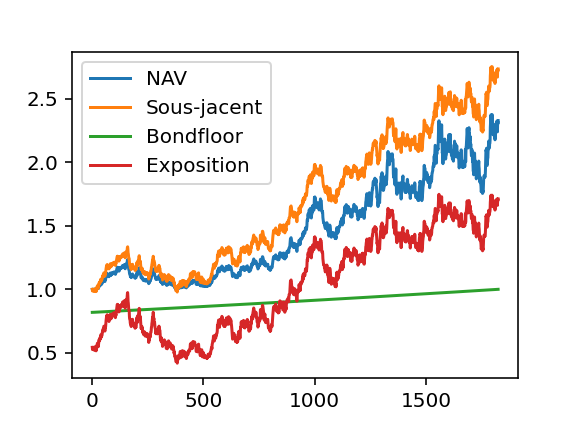

In [6]:
multiplicateur_wid = pn.widgets.IntSlider(name='multiplicateur', value=3, start=1, end=10)
garantie_wid = pn.widgets.FloatSlider(name='garantie', value=1, start=0, end=1, step=0.1)

reactive_fond_methode_coussin = pn.bind(fond_methode_coussin, multiplicateur_wid, garantie_wid)

widgets = pn.Column(multiplicateur_wid, garantie_wid)
reactive_output_fond_methode_coussin = pn.Row(reactive_fond_methode_coussin, widgets)
reactive_output_fond_methode_coussin

## Exercice 3

Calculs des rendements annualisés pour le fond et l'indice. Ainsi que de la volatilité annualisée.

In [7]:
# Rendements :

df_rendement = pd.DataFrame(columns=['3M', '6M', '1Y', '3Y', '5Y'])

T = maturity_wid.value

# Fond
df_rendement.loc["Fond"] = {
    "5Y": (df_nav.loc[T]["NAV"]/df_nav.loc[0]["NAV"])**(365/(T)) - 1,
    "3Y": (df_nav.loc[T]["NAV"]/df_nav.loc[2 * 365]["NAV"])**(365/(T - 2*365)) - 1,
    "1Y": (df_nav.loc[T]["NAV"]/df_nav.loc[4 * 365]["NAV"])**(365/(T - 4*365)) - 1,
    "6M": (df_nav.loc[T]["NAV"]/df_nav.loc[6 * 30 + 4 * 365]["NAV"])**(365/(T - (6 * 30 + 4 * 365))) - 1,
    "3M": (df_nav.loc[T]["NAV"]/df_nav.loc[9 * 30 + 4 * 365]["NAV"])**(365/(T - (9 * 30 + 4 * 365))) - 1,
}

# Indice
df_rendement.loc["Indice"] = {
    "5Y": (df_s.loc[T]["Sous-jacent"]/df_s.loc[0]["Sous-jacent"])**(365/(T)) - 1,
    "3Y": (df_s.loc[T]["Sous-jacent"]/df_s.loc[2 * 365]["Sous-jacent"])**(365/(T - 2*365)) - 1,
    "1Y": (df_s.loc[T]["Sous-jacent"]/df_s.loc[4 * 365]["Sous-jacent"])**(365/(T - 4*365)) - 1,
    "6M": (df_s.loc[T]["Sous-jacent"]/df_s.loc[6 * 30 + 4 * 365]["Sous-jacent"])**(365/(T - (6 * 30 + 4 * 365))) - 1,
    "3M": (df_s.loc[T]["Sous-jacent"]/df_s.loc[9 * 30 + 4 * 365]["Sous-jacent"])**(365/(T - (9 * 30 + 4 * 365))) - 1,
}

df_rendement

,3M,6M,1Y,3Y,5Y
Fond,0.986332,0.220415,0.334735,0.242005,0.183996
Indice,0.642920,0.206960,0.286314,0.251722,0.222697


In [8]:
# Volatilités :
df_vol = pd.DataFrame(columns=['Vol. Annualisé'])
df_rdm_quotidien = pd.DataFrame(columns=["NAV", "Indice"])
df_rdm_quotidien.loc[0] = 1

# Définir le même T choisi précedemment
T = 5 * 365

# Fond
df_rdm_quotidien = pd.DataFrame(df_nav.NAV/df_nav.NAV.shift(1), columns=["NAV", "Indice"])
df_rdm_quotidien.loc[0] = 1
moy_rend_fond = np.mean(df_rdm_quotidien.NAV)
df_vol.loc["Fond"] = (1 / (T - 1) ) * sum(df_rdm_quotidien.NAV.apply(lambda x: (x - moy_rend_fond)**2)) * sqrt(365)

# Indice
df_rdm_quotidien.Indice = df_s["Sous-jacent"]/df_s["Sous-jacent"].shift(1)
df_rdm_quotidien.loc[0] = 1
moy_rend_indice = np.mean(df_rdm_quotidien.Indice)
df_vol.loc["Indice"] = (1 / (T - 1) ) * sum(df_rdm_quotidien.Indice.apply(lambda x: (x - moy_rend_indice)**2)) * sqrt(365)

df_vol

,Vol. Annualisé
Fond,0.002814
Indice,0.002185
